In [1]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun
import reg_icp as ricp

In [2]:
# Loading data sets
cell_profiler = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/regression_data_batchA.csv')
print(f'There are {len(cell_profiler)} rows in the Batch A')

There are 5167 rows in the Batch A


### Feature selection

So far I have filtered all the columns that contained something related to the MITO chanell. Now, according to the paper "A phenomic approach for antiviral drug discovery", there are features, specifically correlation, 
neighbours, concavalin and syto, that are more important. Hence, I am going to filter more to use only that information. 

In [3]:
# Selecting features according to the paper
group1 = [col for col in cell_profiler.columns if ('Granu' in col  and 'SYTO' in col) or ('Inten' in col and 'SYTO' in col) and not 'Location' in col and not 'Radial' in col]
group2 = [col for col in cell_profiler.columns if ('Granu' in col  and 'CONC' in col) or ('Inten' in col and 'CONC' in col) and not 'Location' in col and not 'Radial' in col]
group3 = [col for col in cell_profiler.columns if 'Correla' in col or 'Neig' in col]

filtered_features = group1+group2+group3

# Filtering
filtered_cell_profiler = cell_profiler[filtered_features+['Target']]

### Now training

1. Creating training and tests sets

In [4]:
# We get the input values
X_filtered =  filtered_cell_profiler.iloc[:,:-1]

# Re-scale
scaler = StandardScaler()
X_filtered = pd.DataFrame(scaler.fit_transform(X_filtered))
X_filtered

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,-0.257914,-0.503403,0.368115,-1.095521,0.177077,-0.430929,0.795305,-0.046790,-1.321457,-0.836086,...,0.170116,0.076296,0.748799,0.169360,-0.087611,0.648681,-0.203668,-0.033160,0.743814,0.100900
1,-1.351104,-0.978272,-1.053952,-0.941708,-0.821612,-1.089779,-2.370635,1.530151,-0.441446,0.073379,...,-0.776891,0.733642,0.276178,0.731734,-0.770309,-1.259507,-0.719190,-0.907220,-1.347615,-1.314692
2,-0.292257,0.206746,0.076387,-0.559541,-0.361829,-0.121880,0.222068,2.100450,-2.210764,-2.021869,...,-0.614305,-0.786486,-0.920356,-1.143140,-0.760895,0.285831,-1.617476,-0.108020,0.564839,-1.243213
3,-1.259874,-1.693025,-2.044711,-3.152486,-3.409335,-2.732680,-2.720392,4.814035,-2.349717,-1.265924,...,-0.800588,3.368160,-2.423337,-1.235297,0.734348,-1.713448,-1.929259,1.127889,-2.226118,-4.486775
4,-1.125852,-1.304193,-0.699630,-0.727178,-0.826347,-0.663788,-0.484115,1.217376,-1.327913,-0.397548,...,-1.279884,-0.715382,0.055487,0.213475,-1.757143,-1.007877,-1.262469,-1.670823,-0.765251,-0.973857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,0.350542,0.622401,0.055192,0.439353,0.994491,0.853169,0.157524,-0.164303,0.301825,0.633466,...,0.196056,0.113013,0.016828,-0.100313,0.076090,-0.028682,-0.091369,0.237186,0.033689,0.317694
5163,0.669399,0.758400,1.809696,0.700002,-0.092329,0.631864,0.470503,-0.634794,0.510016,0.671948,...,0.126944,0.582826,0.207708,0.359684,0.784367,0.052846,0.619493,0.865013,0.070952,0.614092
5164,1.569386,1.777094,1.089193,0.563271,0.849976,0.478177,0.878359,-0.736187,0.917663,0.617015,...,1.293937,0.712350,-0.155374,0.377773,1.247087,-0.225002,1.372138,0.984667,-0.556620,0.879421
5165,-0.205780,-0.207491,0.691815,0.442894,0.047307,0.353626,-0.649646,-0.652776,1.547321,1.198609,...,0.470867,0.184642,0.455690,0.281784,0.432123,0.098151,0.763248,0.342401,0.017309,0.964534


In [5]:
# Output values
y = 1000*filtered_cell_profiler.iloc[:,-1].reset_index(drop=True)

**Evaluating baseline models in the training dataset**

In [6]:
#Parameters
thr = 7.5
cv_k = 5

In [7]:
# build multiple linear regression model
model1 = LinearRegression()
model2 = Lasso(random_state=0)
model3 = Ridge(random_state=0)
model4 = svm.SVR()
MODELS = [model1, model2, model3, model4]

MMS_x_filt, BF1_scores_x_filt = fun.train_kfold_model_selection_v2(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = MODELS)

---- Model: LinearRegression()
---- Model: Lasso(random_state=0)
---- Model: Ridge(random_state=0)
---- Model: SVR()


In [8]:
# Second part
model5 = DecisionTreeRegressor(random_state=0)
model6 = RandomForestRegressor(random_state=0)
model7 = BaggingRegressor(random_state=0)
model8 = AdaBoostRegressor(random_state=0)
MODELS = [model5, model6, model7, model8]

MMS_x_filt_2, BF1_scores_x_filt_2 = fun.train_kfold_model_selection_v2(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = MODELS)

---- Model: DecisionTreeRegressor(random_state=0)
---- Model: RandomForestRegressor(random_state=0)
---- Model: BaggingRegressor(random_state=0)
---- Model: AdaBoostRegressor(random_state=0)


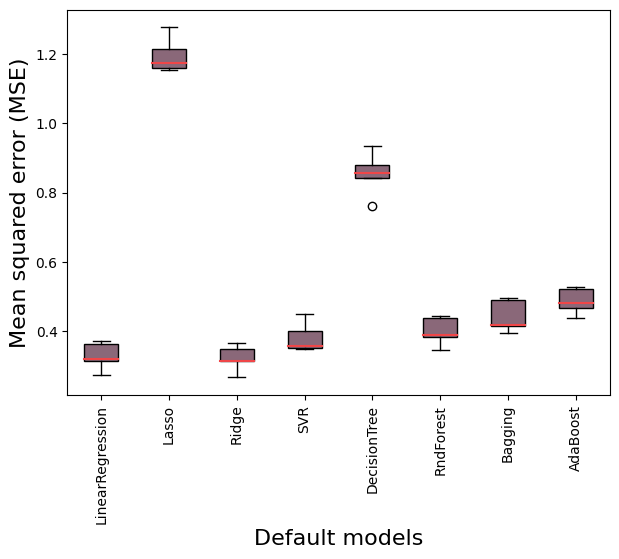

In [13]:
# Showing results
exp1 = list(MMS_x_filt.values())+list(MMS_x_filt_2.values())
models_name = ['LinearRegression','Lasso','Ridge','SVR','DecisionTree','RndForest','Bagging','AdaBoost'] #For labels

# Plot
medianprops = dict(linestyle='-', linewidth=1.5, color=(.937, .275, .282))
fig, ax = plt.subplots(1, 1, figsize=(7,5))
bp = ax.boxplot(exp1,labels=models_name,patch_artist=True, medianprops=medianprops)
#Changing colour of the boxes
for patch, color in zip(bp['boxes'], [(.345, .157, .255, 0.7)]*8):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k')   
ax.set_ylabel('Mean squared error (MSE)', color="black", fontsize=16)   
ax.set_xlabel('Default models', color="black", fontsize=16)
ax.grid(False)
plt.xticks(rotation=90)
#plt.savefig('regression_default_mse_batchA.jpg',bbox_inches='tight', dpi=150)
plt.show()

### Hyper-parameter tunning

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
# Sets for training
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=6752)

In [15]:
# ----------- LINEAR REGRESSION

#Create the grid
grid_vals1 = {'fit_intercept': [True, False]}
grid_lr1 = GridSearchCV(estimator=model1, param_grid=grid_vals1, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result1 = grid_lr1.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result1.best_score_)
print('Best Hyperparameters: %s' % result1.best_params_)

Best Score: -0.3272556118238763
Best Hyperparameters: {'fit_intercept': True}


In [16]:
# ----------- LINEAR REGRESSION WITH RIDGE REGULARIZATION

#Create the grid
grid_vals3 = {'alpha': [0.001,0.01,0.1,1.0,1.1,1.3,1.5], 'fit_intercept': [True, False]}
grid_lr3 = GridSearchCV(estimator=model3, param_grid=grid_vals3, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result = grid_lr3.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.32421705988127103
Best Hyperparameters: {'alpha': 1.3, 'fit_intercept': True}


In [17]:
# ----------- SUPPORT VECTOR MACHINES FOR REGRESSION

#Create the grid
grid_vals4 = {'kernel': ["poly", "rbf", "sigmoid"], 'gamma': [1.0, 0.1, 1e-2], 'C': [1, 10, 30, 50, 80, 100]}
grid_lr4 = GridSearchCV(estimator=model4, param_grid=grid_vals4, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result4 = grid_lr4.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result4.best_score_)
print('Best Hyperparameters: %s' % result4.best_params_)

Best Score: -0.5428358825491049
Best Hyperparameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [19]:
# ----------- DECISION TREE: I will use this as the base estimator for bagging

#Create the grid
grid_vals5 = {'splitter':['best', 'random'], 'min_samples_split':[2,5,7,10], 'max_depth':[None,5,10,15,20], }
grid_lr5 = GridSearchCV(estimator=model5, param_grid=grid_vals5, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result5 = grid_lr5.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result5.best_score_)
print('Best Hyperparameters: %s' % result5.best_params_)

Best Score: -0.5357515860010025
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2, 'splitter': 'best'}


In [16]:
# ----------- RANDOM FOREST

#Create the grid
grid_vals6 = {'n_estimators': [30,50,100,150,200], 'max_depth': [None,3,5,9,12], 'min_samples_leaf': [1,2,3],'random_state': [0],'n_jobs':[-1]}
grid_lr6 = GridSearchCV(estimator=model6, param_grid=grid_vals6, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result6 = grid_lr6.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result6.best_score_)
print('Best Hyperparameters: %s' % result6.best_params_)

Best Score: -0.4141601039813655
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 0}


In [18]:
# ----------- BAGGING

#Create the grid
base = DecisionTreeRegressor(max_depth = 5, min_samples_split = 10, splitter = "best", random_state=0)
grid_vals7 = {'base_estimator':[base],'n_estimators': [10,30,50,70,100], 'max_features':[0.25,0.5,1.0]}
grid_lr7 = GridSearchCV(estimator=model7, param_grid=grid_vals7, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result7 = grid_lr7.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result7.best_score_)
print('Best Hyperparameters: %s' % result7.best_params_)

Best Score: -0.45432379715643256
Best Hyperparameters: {'base_estimator': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=0), 'max_features': 0.5, 'n_estimators': 100}


In [19]:
# ----------- ADABOOST

#Create the grid
grid_vals8 = {'base_estimator':[base], 'n_estimators': [10,30,50,70,100], 'learning_rate': [1.5, 1.0, 0.1, 1e-2]}
grid_lr8 = GridSearchCV(estimator=model8, param_grid=grid_vals8, scoring='neg_mean_squared_error', 
                       cv=5, refit=True, return_train_score=True)

#Training and Prediction
result8 = grid_lr8.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result8.best_score_)
print('Best Hyperparameters: %s' % result8.best_params_)

Best Score: -0.4259373958581033
Best Hyperparameters: {'base_estimator': DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=0), 'learning_rate': 1.5, 'n_estimators': 100}


**Best models comparision**

In [20]:
# Building the models
best_ridge = Ridge(alpha=1.3, random_state=0)
best_svr = svm.SVR(C=10, gamma=0.01)
best_tree = DecisionTreeRegressor(max_depth = 5, random_state=0)
best_rf = RandomForestRegressor(min_samples_leaf = 3, n_estimators = 200, n_jobs=-1,random_state=0)
best_bag = BaggingRegressor(base_estimator = best_tree, max_features = 0.5, n_estimators=100, random_state=0)
best_ada = AdaBoostRegressor(base_estimator = best_tree, n_estimators = 100, random_state=0)

BEST_MODELS = [model1,best_ridge, best_svr, best_tree, best_rf, best_bag, best_ada]

In [21]:
Best_MMS_x_filt_v2, Best_BF1_scores_x_filt_v2 = fun.train_kfold_model_selection_v2(X = X_filtered, y = y, 
                                                              kfold = cv_k, threshold = thr, 
                                                              model_list = BEST_MODELS)

---- Model: LinearRegression()
---- Model: Ridge(alpha=1.3, random_state=0)
---- Model: SVR(C=10, gamma=0.01)
---- Model: DecisionTreeRegressor(max_depth=5, random_state=0)
---- Model: RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1,
                      random_state=0)
---- Model: BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                      random_state=0),
                 max_features=0.5, n_estimators=100, random_state=0)
---- Model: AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=0),
                  n_estimators=100, random_state=0)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9,5))
bp0 = ax.boxplot(accuracy, labels = None, positions = np.arange(np.array(accuracy).shape[0])-0.3, widths = 0.3, patch_artist = True, medianprops = medianprops)
bp1 = ax.boxplot(f1score, labels = None, positions = np.arange(np.array(f1score).shape[0])+0.3, widths = 0.3, patch_artist = True, medianprops = medianprops)

#Changing colour
for patch, color in zip(bp0['boxes'], [(.345, .157, .255, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 
for patch, color in zip(bp1['boxes'], [(.937, .275, .282, 0.75)]*7):
    patch.set_facecolor(color)
    patch.set_linewidth(1)
    patch.set_edgecolor('k') 

ax.set_ylabel('MSE / F1-score', color="black", fontsize=16)   
ax.set_xlabel('Best models after Grid search', color="black", fontsize=16)
ax.grid(False)
plt.xticks(ticks= np.arange(0,7),labels = models_name,rotation=90)

#plt.savefig('repeated_compounds.jpg',bbox_inches='tight', dpi=150)
plt.show()

In [22]:
Best_MMS_x_filt_v2


{'LinearRegression()': [0.27199071124529994,
  0.3613204320348623,
  0.3132035309347615,
  0.3698480752555245,
  0.31958855083779814],
 'Ridge(alpha=1.3, random_state=0)': [0.26620027534722174,
  0.3474972008673434,
  0.3136136910186813,
  0.36605992186989983,
  0.31416452712214404],
 'SVR(C=10, gamma=0.01)': [0.49630429337093884,
  0.5348090180300417,
  0.4890993907203099,
  0.5980412591552927,
  0.48807294266348816],
 'DecisionTreeRegressor(max_depth=5, random_state=0)': [0.44598930376206747,
  0.5426961894036274,
  0.5062176270185329,
  0.550187507086545,
  0.5096590375684459],
 'RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1,\n                      random_state=0)': [0.34098766857033275,
  0.4395711648121322,
  0.3796501225140667,
  0.4418045117627952,
  0.38619414047134],
 'BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,\n                                                      random_state=0),\n                 max_features=0.5, n_estimators

In [23]:
Best_BF1_scores_x_filt_v2

{'LinearRegression()': [0.7812500000000001,
  0.7755102040816326,
  0.875,
  0.7719298245614034,
  0.8181818181818182],
 'Ridge(alpha=1.3, random_state=0)': [0.7936507936507937,
  0.7916666666666666,
  0.8571428571428572,
  0.8135593220338982,
  0.9230769230769231],
 'SVR(C=10, gamma=0.01)': [0.42553191489361697,
  0.32258064516129037,
  0.5454545454545454,
  0.42105263157894735,
  0.5517241379310346],
 'DecisionTreeRegressor(max_depth=5, random_state=0)': [0.6875,
  0.7272727272727274,
  0.8085106382978724,
  0.7450980392156864,
  0.75],
 'RandomForestRegressor(min_samples_leaf=3, n_estimators=200, n_jobs=-1,\n                      random_state=0)': [0.7457627118644068,
  0.7391304347826088,
  0.8936170212765957,
  0.7307692307692308,
  0.8205128205128205],
 'BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,\n                                                      random_state=0),\n                 max_features=0.5, n_estimators=100, random_state=0)': [0.745762711864406